In [9]:
import pandas as pd
import numpy as np
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import datetime

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.formula.api  import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
#rawdata = pd.read_csv (r'/Users/cairo/Google Drive/wechat data/016.csv', encoding='utf-8')

# Take the first 1,000,000 articles as the current data for analysis
topicdata = pd.read_csv(r'/Users/cairo/Google Drive/wechat data/TopicOutcomeAll20Topic.csv', nrows = 1000000, sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

#group the data by its account name
DF_list= list()
for i in topicdata.account.unique():
   dff = topicdata[topicdata["account"].isin([i])]
   dff["std"] = dff.filter(like='topic', axis=1).astype(float).std(axis = 1)
   DF_list.append(dff)
   
#reformat articles' public time
qq4 = []
for j in DF_list:
    qq3 = []
    for i in j["publicTime"]:
        qq = datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
        qq2 = [qq.year, qq.month, qq.day]
        qq3.append(qq2)
    qq4.append(qq3)

#group the data by its account name with the reformatted public time
DF_list2 = []
for index, item in enumerate(DF_list):
    df2 = pd.DataFrame(qq4[index]) 
    df2a = df2.rename(columns={0: "year", 1: "month", 2:"day"})
    df2a.index = item.index
    df4 = pd.concat([item, df2a], axis=1)
    DF_list2.append(df4)



<ipython-input-2-393eedd8757a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["std"] = dff.filter(like='topic', axis=1).astype(float).std(axis = 1)


### Demenstrate 6415 articles of an account named "南京吃喝玩乐"

In [8]:
DF_list2[0].head  

<bound method NDFrame.head of           name         account  author type                          title  \
0       南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生           住宾馆时，怎么知道房间有没有针孔摄像头？   
2       南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生            ▶太恶心了，吃火锅前一定要注意，速看！   
4       南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生                太有用了！看到第二个我就收了!   
7       南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生              南京人童年殿堂级零食 你吃过多少？   
9       南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生     和一个南京人讨论n、l 的后果。。。别怪我没提醒你！   
...        ...             ...     ...  ...                            ...   
256921  南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生              大厂又要在全国出名了，刷爆朋友圈！   
256936  南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生               测完这十几种水，我决定只喝这款！   
257139  南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生         紧急通知：南京的三伏天来了！还有17级台风！   
257146  南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生                    对不起，我要去徐州了！   
257176  南京吃喝玩乐  happyinnanjing  南京吃喝玩乐   民生  太惊艳了！这个隐藏在市中心的“苏式园林”，每一步都是风景！   

                                 

###  Examples of the word loading within each topics derived from LDA topic modeling (manually translated to English for illustration purpose)

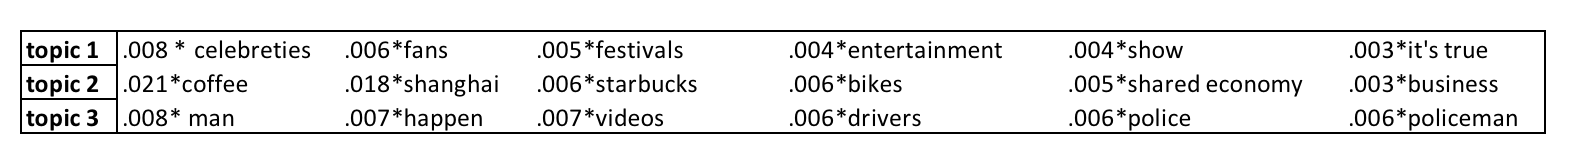

In [5]:
#take the mean values of topic weights, clicksCount, and likeCount in each time window (i.e., each month). 
#For instance, it output the average weight of topic1 and average likeCount of Dec 2015.

monthstd_list=[]
for j in DF_list2:
    j.topic1 = j.topic1.astype(float)
    j.topic2 = j.topic2.astype(float)
    j.topic3 = j.topic3.astype(float)
    j.topic4 = j.topic4.astype(float)
    j.topic5 = j.topic5.astype(float)
    j.topic9 = j.topic9.astype(float)
    j.topic14 = j.topic14.astype(float)
    j.topic15 = j.topic15.astype(float)
    j.clicksCount = j.clicksCount.astype(float)
    j.likeCount = j.likeCount.astype(float)
    jj = j.groupby(['year','month']).agg(topic1=('topic1', 'mean'),topic2=('topic2', 'mean'), topic3=('topic3', 'mean')
                                         , topic4=('topic4', 'mean'), topic5=('topic5', 'mean'), 
                                         clicksCount=('clicksCount', 'mean'), likeCount=('likeCount', 'mean')).reset_index(drop=False)
    monthstd_list.append(jj)
    
flat_monthstd = pd.concat(monthstd_list) #Data was grouped in list by each account. This part flattern the list

In [6]:
flat_monthstd.head

<bound method NDFrame.head of     year  month     topic1     topic2    topic3      topic4     topic5  \
0   2015      1   0.922486   1.719363  4.423722    4.400268  28.019658   
1   2015      2   0.935621   6.952455  0.860181    6.917418  35.531865   
2   2015      3   1.302099   2.922652  6.672153    6.853633  67.321642   
3   2015      4   0.879632   4.326970  2.867779    7.504997  37.879166   
4   2015      5   1.024153   1.862016  3.998951   11.824082  50.615131   
..   ...    ...        ...        ...       ...         ...        ...   
22  2018      7   9.346743   8.607780  5.898684  126.040131   0.560515   
0   2018      5   0.050000  32.523429  0.050000    0.050000   0.050000   
1   2018      6   0.050000   0.050000  0.050000    0.050000   0.050000   
2   2018      7   0.204301   2.851731  0.050000   13.586685   0.050000   
0   2018      7  15.597619  14.012298  0.050000    8.142796   1.293266   

     clicksCount    likeCount  
0   23214.129496   150.287770  
1   18629.318471 

### Plot the correlation between each topic with likeCount across time, the results show that the popularity of different topics evolves signficantly over time. Some topics are becoming more popular and some are becoming less popular

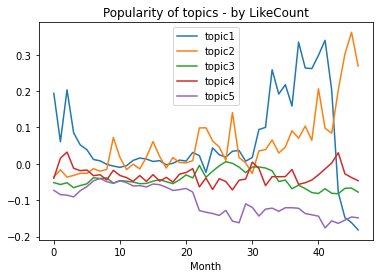

In [17]:
corrall1 = flat_monthstd.groupby(flat_monthstd.index)[['topic1','likeCount']].corr().unstack().iloc[:,1].to_frame()
corrall2 = flat_monthstd.groupby(flat_monthstd.index)[['topic2','likeCount']].corr().unstack().iloc[:,1].to_frame()
corrall3 = flat_monthstd.groupby(flat_monthstd.index)[['topic3','likeCount']].corr().unstack().iloc[:,1].to_frame()
corrall4 = flat_monthstd.groupby(flat_monthstd.index)[['topic4','likeCount']].corr().unstack().iloc[:,1].to_frame()
corrall5 = flat_monthstd.groupby(flat_monthstd.index)[['topic5','likeCount']].corr().unstack().iloc[:,1].to_frame()

plt.title('Popularity of topics - by LikeCount')
plt.xlabel('Month')
plt.plot(corrall1, label='topic1')
plt.plot(corrall2, label='topic2')
plt.plot(corrall3, label='topic3')
plt.plot(corrall4, label='topic4')
plt.plot(corrall5, label='topic5')
plt.legend()
plt.show()

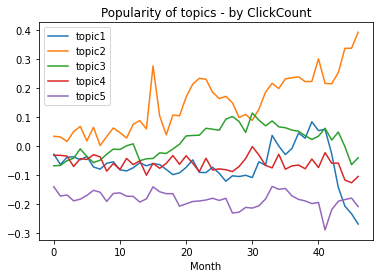

In [18]:
corrall1 = flat_monthstd.groupby(flat_monthstd.index)[['topic1','clicksCount']].corr().unstack().iloc[:,1].to_frame()
corrall2 = flat_monthstd.groupby(flat_monthstd.index)[['topic2','clicksCount']].corr().unstack().iloc[:,1].to_frame()
corrall3 = flat_monthstd.groupby(flat_monthstd.index)[['topic3','clicksCount']].corr().unstack().iloc[:,1].to_frame()
corrall4 = flat_monthstd.groupby(flat_monthstd.index)[['topic4','clicksCount']].corr().unstack().iloc[:,1].to_frame()
corrall5 = flat_monthstd.groupby(flat_monthstd.index)[['topic5','clicksCount']].corr().unstack().iloc[:,1].to_frame()

plt.title('Popularity of topics - by ClickCount')
plt.xlabel('Month')
plt.plot(corrall1, label='topic1')
plt.plot(corrall2, label='topic2')
plt.plot(corrall3, label='topic3')
plt.plot(corrall4, label='topic4')
plt.plot(corrall5, label='topic5')
plt.legend()
plt.show()